### Classification

Using Classification, we will try to predict whether an observation belongs to the Responsive or Non-Responsive group. We will try a Logistic Regression model to do the classification, and if needed a Random Forest model.

In [1]:
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.model_selection import GridSearchCV

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Read in the data file
clothingFile = pd.read_table('Clothing_Store',sep=',')
clothingFile.head()

,HHKEY,ZIP_CODE,REC,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
0,9955600066402,1001,208,2,368.46,0,184.23,11,0.18,0.00,...,N,0,5,0,0.00,31.81,111.00,10,0.00,0
1,9955600073501,1028,6,4,258.00,1,64.50,11,0.26,0.16,...,Y,0,4,2,50.00,32.72,43.50,10,0.03,1
2,9955600076313,1056,327,2,77.00,0,38.50,11,1.00,0.00,...,N,0,4,0,0.00,100.00,68.60,16,0.00,0
3,9955600078045,1118,66,8,846.06,1,105.75,11,0.38,0.00,...,Y,0,9,6,66.67,23.27,26.96,10,0.00,0
4,9955600078517,1107,49,1,87.44,0,87.44,11,0.20,0.20,...,Y,0,0,0,0.00,28.52,24.50,20,0.00,0


### Prepare dataframe for input to Logistic Regression model.

#### Column Descriptions

- 'HHKEY' - Customer ID: unique, encrypted customer identification
- 'ZIP_CODE' - Zip code
- 'REC' - a variable showing the brand of choice (encrypted)
- 'FRE' - Number of purchase visits
- 'MON' - Total net sales
- 'CC_CARD' - Flag: credit card user
- 'AVRG' - Average amount spent per visit
- 'PC_CALC20',
- 'PSWEATERS' - percentages spent by the customer on Sweaters
- 'PKNIT_TOPS' - percentages spent by the customer on knit tops
- 'PKNIT_DRES' - percentages spent by the customer on knit dresses
- 'PBLOUSES' - percentages spent by the customer on blouses
- 'PJACKETS' - percentages spent by the customer on jackets
- 'PCAR_PNTS' - percentages spent by the customer on career pants
- 'PCAS_PNTS' - percentages spent by the customer on casual pants
- 'PSHIRTS' - percentages spent by the customer on shirts
- 'PDRESSES' - percentages spent by the customer on dresses
- 'PSUITS' - percentages spent by the customer on suits
- 'POUTERWEAR' - percentages spent by the customer on outerwear
- 'PJEWELRY' - percentages spent by the customer on jewelry
- 'PFASHION' - percentages spent by the customer on fashion
- 'PLEGWEAR' - percentages spent by the customer on legwear
- 'PCOLLSPND' - percentages spent by the customer on collectibles line
- 'AMSPEND' - Spending at the AM store
- 'PSSPEND' - Spending at the PS store
- 'CCSPEND' - Spending at the CC store
- 'AXSPEND' - Spending at the AX store
- 'TMONSPEND' - Amount spent in the past three months
- 'OMONSPEND' - Amount spent in the past month
- 'SMONSPEND' - Amount spent in the past six months
- 'PREVPD',
- 'GMP' - Gross margin percentage
- 'PROMOS' - Number of marketing promotions on file
- 'DAYS' - Number of days the customer has been on file
- 'FREDAYS' - Number of days between purchases
- 'MARKDOWN' - Markdown percentage on customer purchases - indicates which customers have purchased merchandise that has been marked down
- 'CLASSES' - Number of different product classes purchased
- 'COUPONS' - Number of coupons used by the customer
- 'STYLES' - Total number of individual items purchased by the customer
- 'STORES' - Number of stores the customer shopped at
- 'STORELOY' - Spending in the same period last year (?)
- 'VALPHON' - Flag: valid phone number on file
- 'WEB' - Flag: Web shopper
- 'MAILED' - Number of promotions mailed in the past year
- 'RESPONDED' - Number of promotions responded to in the past year
- 'RESPONSERATE' - Promotion response rate for the past year - indicates which customers have ever responded to a marketing promotion before
- 'HI' - Product uniformity (low score = diverse spending patterns)
- 'LTFREDAY' - Lifetime average time between visits
- 'CLUSTYPE' - Microvision lifestyle cluster type
- 'PERCRET' - Percent of returns
- 'RESP' - Target variable: response to promotion

Categorical Columns: CC_Card, VALPHON, WEB, CLUSTYPE, RESP

Column with Unique Values: HHKEY

Categorical columns need to be in 0/1 format. Categorical columns with more than one category need to be flattened out so they can also have 0/1 format.

In [3]:
# Change VALPHON to 0 and 1 instead of N and Y
clothingFile.VALPHON.replace(('Y', 'N'), (1, 0), inplace=True)
clothingFile.head()

,HHKEY,ZIP_CODE,REC,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
0,9955600066402,1001,208,2,368.46,0,184.23,11,0.18,0.00,...,0,0,5,0,0.00,31.81,111.00,10,0.00,0
1,9955600073501,1028,6,4,258.00,1,64.50,11,0.26,0.16,...,1,0,4,2,50.00,32.72,43.50,10,0.03,1
2,9955600076313,1056,327,2,77.00,0,38.50,11,1.00,0.00,...,0,0,4,0,0.00,100.00,68.60,16,0.00,0
3,9955600078045,1118,66,8,846.06,1,105.75,11,0.38,0.00,...,1,0,9,6,66.67,23.27,26.96,10,0.00,0
4,9955600078517,1107,49,1,87.44,0,87.44,11,0.20,0.20,...,1,0,0,0,0.00,28.52,24.50,20,0.00,0


In [4]:
# Make CLUSTYPE separate columns of 0 and 1.
clothingFileLR = pd.get_dummies(clothingFile,columns=['CLUSTYPE'])

In [5]:
print(clothingFileLR.shape)
clothingFileLR.head()

(21740, 101)


,HHKEY,ZIP_CODE,REC,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,...,CLUSTYPE_41,CLUSTYPE_42,CLUSTYPE_43,CLUSTYPE_44,CLUSTYPE_45,CLUSTYPE_46,CLUSTYPE_47,CLUSTYPE_48,CLUSTYPE_49,CLUSTYPE_50
0,9955600066402,1001,208,2,368.46,0,184.23,11,0.18,0.00,...,0,0,0,0,0,0,0,0,0,0
1,9955600073501,1028,6,4,258.00,1,64.50,11,0.26,0.16,...,0,0,0,0,0,0,0,0,0,0
2,9955600076313,1056,327,2,77.00,0,38.50,11,1.00,0.00,...,0,0,0,0,0,0,0,0,0,0
3,9955600078045,1118,66,8,846.06,1,105.75,11,0.38,0.00,...,0,0,0,0,0,0,0,0,0,0
4,9955600078517,1107,49,1,87.44,0,87.44,11,0.20,0.20,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Remove Customer ID dimension - Unique values
clothingFileLR.drop(['HHKEY'],axis=1,inplace=True)

In [7]:
# Remove Target Variable
clothingFileLRnoRESP = clothingFileLR.drop(['RESP'],axis=1)

### Training and Test Datasets

When fitting models, we want to ensure...
- We have found the best parameters for our model, and therefore, the best model.
- The model is highly likely to predict well on unseen data.

To do this, we will split the data into a training set and a test set. We will train the model on the training set and test the model's accuracy on the test set.

In [8]:
# Create the first parameter of train_test_split - a matrix
columnNames = list(clothingFileLRnoRESP)
X = clothingFileLRnoRESP[columnNames].values
print("X: ", type(X), X.shape)

('X: ', <type 'numpy.ndarray'>, (21740, 99))


In [9]:
# Create the second parameter - each customers' response to the promotion
y = clothingFileLR[['RESP']].values
print("y: ", type(y), y.shape)

('y: ', <type 'numpy.ndarray'>, (21740, 1))


X and y have the following relationships...

1. They have the same number of rows
2. For a given row i of matrix X, the label that corresponds to that data point is exactly the value of vector y at that row
3. The number of rows of X is the number of data points in the dataset
4. The number of columns of X is the number of features of each data point in the dataset

In [10]:
# Split the data into a training set and a test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,random_state=5)

In [11]:
#By default train_test_split splits to 75% train and 25% test
#Setting the Random State to a fixed number will guarantee that the output of Run 1 will be equal to the output
#of Run 2, i.e. your split will be always the same

# Look at the objects the split returned...

# Xtrain
print("\n")
print("Xtrain:", Xtrain, type(Xtrain), Xtrain.shape, len(Xtrain))

# Xtest
print("\n")
print("Xtest", Xtest, type(Xtest), Xtest.shape, len(Xtest))

# ytrain
print("\n")
print("ytrain", ytrain, type(ytrain), ytrain.shape, len(ytrain))

# ytest:
print("\n")
print("ytest", ytest, type(ytest), ytest.shape, len(ytest))



('Xtrain:', array([[  7.86410000e+04,   1.17000000e+02,   3.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.87090000e+04,   1.60000000e+01,   3.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  4.41460000e+04,   8.00000000e+00,   1.60000000e+01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  9.17920000e+04,   3.45000000e+02,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.70840000e+04,   5.80000000e+01,   7.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.08540000e+04,   2.90000000e+01,   1.00000000e+01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]]), <type 'numpy.ndarray'>, (16305, 99), 16305)


('Xtest', array([[  9.00370000e+04,   3.50000000e+01,   2.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
     

### Logistic Regression

As expected, the split is 75% train and 25% test data.

In [12]:
# Construct the Logistic Regression model
clf = LogisticRegression()

# Fit the model on the training data
clf.fit(Xtrain, ytrain) 

# Print the training score
y_predict_training = clf.predict(Xtrain)
print("\n")
print("[Training] Accuracy score: (y_predict_training,ytrain)",accuracy_score(y_predict_training,ytrain))

# Print the accuracy from the testing data
y_predict_test = clf.predict(Xtest)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest):",accuracy_score(y_predict_test, ytest))

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)




('[Training] Accuracy score: (y_predict_training,ytrain)', 0.85194725544311556)


('[Test] Accuracy score (y_predict_test, ytest):', 0.84765409383624657)


Training accuracy: The model's training accuracy is pretty good at 85.1947%, which indicates there is no bias in the model.

Test accuracy: The test accuracy and the training accuracy have fairly close scores, so there is no variance between the two. This is good because it indicates the model will generalize well. Meaning when new data is presented, the model will perform similarly.

The lack of bias and variance are two desirable and important characteristics. Classification accuracy is best used when treating the entire population. It weights all errors equally and lumps them into one group. The issue is there may be different tolerances for different errors. For example, if Threads wanted to be sure to reach *all* customers who are predicted to respond to the promotion (no Type I errors), and they did not mind sending the promotion to "extra" customers who will not respond (some Type II errors) then we will want to look at other metrics.

In [13]:
# More comprehensive performance analysis

print("[Training Classification Report:]")
print(classification_report(ytrain, y_predict_training))

print("[Test Classification Report:]")
print(classification_report(ytest, y_predict_test))

[Training Classification Report:]
             precision    recall  f1-score   support

          0       0.86      0.98      0.92     13615
          1       0.66      0.21      0.32      2690

avg / total       0.83      0.85      0.82     16305

[Test Classification Report:]
             precision    recall  f1-score   support

          0       0.86      0.98      0.91      4514
          1       0.65      0.21      0.32       921

avg / total       0.82      0.85      0.81      5435



Precision: Precision is the number of true positive results divided by the number of total (true and false) positive results. It measures the quality of the classification.

Recall: Recall is the number of true positive results divided by the true positives and false negatives (items that should've been in the positive class, but were not). This is a measure of completeness.

f1 Score: The F1 score is a weighted average of the precision and recall. An F1 score reaches its best value at 1 and worst score at 0.

Support: The number of occurences in each class.

The results are similar between the training and test sets, so we will focus on the test data metrics. For the test data, the precision is 86% for the Non-Responsive customers and 65% for the Responsive customers. The recall is 98% for the Non-Responsive customers and only **21% for the Responsive customers, meaning it is missing many of the customers who should be marked as responsive**.

### Tuning the Logistic Regression Model

We will now tune some hyperparameters to hopefully improve performance. We will use cross-validation. In Logistic Regression, the most important parameter to tune is the regularization parameter C. The regularization parameter is used to control for unlikely high regression coefficients, and in other cases can be used when data is sparse, as a method of feature selection.

We use the following cv_score function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.

In [14]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

Below is an example of using the cv_score function for a basic logistic regression model without regularization.

In [15]:
clf = LogisticRegression()
score = cv_score(clf, Xtrain, ytrain)
print(score)

0.851456608402


Below is a list of C values. For each value of C, we will use the training set to create a logistic regression model and find the average score for the model. We will then pick the C with the highest average score.

In [16]:
# The list of C values
Cs = [0.001, 0.1, 1, 10, 100]

max_score = 0

for C in Cs:
        clf = LogisticRegression(C=C)
        score = cv_score(clf, Xtrain, ytrain)

        if score > max_score:
            max_score = score
            best_C = C
print max_score, best_C

0.851824593683 10


Now we will test on the test set.

In [17]:
clfl = LogisticRegression(C=best_C)
clfl.fit(Xtrain, ytrain)
ypred = clfl.predict(Xtest)
accuracy_score(ypred, ytest)

0.84783808647654091

Run the Classification Report with the "best" C value (C=10).

In [18]:
print("[Test Classification Report with C=10:]")
print(classification_report(ytest, ypred))

[Test Classification Report with C=10:]
             precision    recall  f1-score   support

          0       0.86      0.98      0.91      4514
          1       0.66      0.21      0.32       921

avg / total       0.82      0.85      0.81      5435



The Classification Report shows the metrics improved very little. Most importantly, the Recall for the '1' or Responsive group did not improve at all. The Recall score will most likely not improve much more with further tuning because there is a large imbalance in the size of the groups. It is difficult to capture all of the responsive customers when there is such a small number within the dataset.

We will now move on to Random Forest.

### Random Forest Model

In [19]:
# Create the Random Forest model
rfCLF = RandomForestClassifier()
# Train the Random Forest model on training data
rfCLF.fit(Xtrain, ytrain.ravel())

# Test Random Forest model on the test data
ypredRF = rfCLF.predict(Xtest)
accuracy_score(ypredRF, ytest)

0.84250229990800363

In [20]:
print("[Test Classification Report from Random Forest:]")
print(classification_report(ytest, ypredRF))

[Test Classification Report from Random Forest:]
             precision    recall  f1-score   support

          0       0.86      0.97      0.91      4514
          1       0.60      0.20      0.31       921

avg / total       0.81      0.84      0.81      5435



The Random Forest Classification Report shows a slight decline in the Recall for the Non-Responsive group, and the Precision for the Responsive group. The Recall for the Responsive customers increased by two percentage points. We will now tune the model to see if we can gain more improvement.

### Tuning the Random Forest Model

We will now tune the hyperparameters for the Random Forest Model. There are many parameters to choose from, so we will use Scikit-Learn’s GridSearchCV method to evaluate combinations from the grid defined below.

In [21]:
# Create the parameter grid 
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 50, 100, 150]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfCLF, param_grid = param_grid)

In [22]:
# Fit the grid search to the data
#grid_search.fit(Xtrain, ytrain.ravel())
#grid_search.best_params_

In [23]:
# Re-create the model with the "best" parameters of 'max_depth'=None,'max_features'=None,'n_estimators'=200
rfCLF1 = RandomForestClassifier(n_estimators=200,max_features=None,max_depth=None)
# Train the updated Random Forest model on training data
rfCLF1.fit(Xtrain, ytrain.ravel())

# Test updated Random Forest model on the test data
ypredRF1 = rfCLF1.predict(Xtest)
accuracy_score(ypredRF1, ytest)

0.85243790248390061

In [24]:
print("[Test Classification Report from Updated Random Forest:]")
print(classification_report(ytest, ypredRF1))

[Test Classification Report from Updated Random Forest:]
             precision    recall  f1-score   support

          0       0.87      0.97      0.92      4514
          1       0.64      0.30      0.40       921

avg / total       0.83      0.85      0.83      5435



The Classification Report for the tuned model looks better, but the Responsive Recall is still very low at 30%. The imbalanced classes make it difficult for the model to accurately capture the Responsive group. The Responsive group is too small (16-17% of the total dataset). We will now move to Resampling to try and compensate for the imbalance and improve the model.

### Resampling

Resampling attempts to balance the class size. Oversampling randomly replicates the minority class to increase the population. Undersampling randomly reduces the majority class to decrease the population size. There are arguments for both methods. We will perform both Logistic Regression and Random Forest on an Oversampled dataset and an Undersampled dataset to compare the results.

#### Oversampling

We will oversample using the SMOTE (Synthetic Minority Oversampling Technique) algorithm. SMOTE finds the k-nearest neighbors of the minority dataset and uses those to create random similar observations. Oversampling can be done before or after the train/test split. The concern with oversampling before the split is "bleeding" the synthetic data into the test set. This would train the model to better predict the test set than a new dataset. For this reason, we will perform the oversampling after the train/test split.

In [25]:
# Oversampling with SMOTE
sm = SMOTE(random_state=42)
X_Ores, y_Ores = sm.fit_sample(Xtrain, ytrain)
print('Resampled dataset shape {}'.format(Counter(y_Ores)))

Resampled dataset shape Counter({0: 13615, 1: 13615})


In [26]:
# Oversampled data with Logistic Regression
clfO = LogisticRegression()

# Fit the model on the training data
clfO.fit(X_Ores, y_Ores) 

# Print the training score
y_predict_trainingLRO = clfO.predict(X_Ores)
print("\n")
print("[Training] Accuracy score: (y_predict_trainingLRO,y_Ores)",accuracy_score(y_predict_trainingLRO,y_Ores))

# Print the accuracy from the testing data
y_predict_testLRO = clfO.predict(Xtest)
print("\n")
print("[Test] Accuracy score (y_predict_testLRO, y_Ores):",accuracy_score(y_predict_testLRO, ytest))



('[Training] Accuracy score: (y_predict_trainingLRO,y_Ores)', 0.77238340066103561)


('[Test] Accuracy score (y_predict_testLRO, y_Ores):', 0.7243790248390064)


In [27]:
# More comprehensive performance analysis of Oversampled Logistic Regression Model

print("[Training Classification Report:]")
print(classification_report(y_Ores, y_predict_trainingLRO))

print("[Test Classification Report:]")
print(classification_report(ytest, y_predict_testLRO))

[Training Classification Report:]
             precision    recall  f1-score   support

          0       0.82      0.70      0.75     13615
          1       0.74      0.84      0.79     13615

avg / total       0.78      0.77      0.77     27230

[Test Classification Report:]
             precision    recall  f1-score   support

          0       0.95      0.70      0.81      4514
          1       0.36      0.82      0.50       921

avg / total       0.85      0.72      0.76      5435



The Test Classification Report shows improved percentages for the precision of the non-responsive group and the recall of the responsive group, but decreased percentages for the recall for the non-responsive group and the precision of the responsive group.

Precision is measuring how many of the predictions the model made correctly. The precision for the non-responsive group is high at 95%. The precision for the non-responsive group is low at 36% - there were many false positives for the non-responsive group.

The recall is looking at how many positive cases the model missed. The non-responsive group recall is 70%; 30% of the positive results are being missed. The responsive group recall is 82%. This is a large improvement from the previous models.

We will now tune the regularization parameter C to test if it improves the model. For each value of C, we will use the training set to create a logistic regression model and find the average score for the model. We will then pick the C with the highest average score.

In [28]:
# The list of C values
Cs = [0.001, 0.1, 1, 10, 100]

max_score = 0

for C in Cs:
        clfLROR = LogisticRegression(C=C)
        score = cv_score(clfLROR, X_Ores, y_Ores)

        if score > max_score:
            max_score = score
            best_C = C
print max_score, best_C

0.677157546823 10


Now test the C with the highest average score on the test set.

In [29]:
clflLROR = LogisticRegression(C=best_C)
clflLROR.fit(X_Ores, y_Ores)
ypredLROR = clflLROR.predict(Xtest)
accuracy_score(ypredLROR, ytest)

0.72419503219871206

Classification Report with the "best" value of C

In [30]:
print("[Test Classification Report with C=10:]")
print(classification_report(ytest, ypredLROR))

[Test Classification Report with C=10:]
             precision    recall  f1-score   support

          0       0.95      0.70      0.81      4514
          1       0.36      0.82      0.50       921

avg / total       0.85      0.72      0.76      5435



There is no change in the metrics with the Logistic Regression hyper-parameterization.

In [31]:
# Oversampled data with Random Forest Model
OrfCLF = RandomForestClassifier()

# Train the Random Forest model on oversampled training data
OrfCLF.fit(X_Ores, y_Ores)

# Test Random Forest model on the test data
ypredORF = OrfCLF.predict(Xtest)
accuracy_score(ypredORF, ytest)

0.81968721251149956

In [32]:
# Classification report for oversampled Random Forest Model
print("[Test Classification Report from Random Forest:]")
print(classification_report(ytest, ypredORF))

[Test Classification Report from Random Forest:]
             precision    recall  f1-score   support

          0       0.87      0.92      0.89      4514
          1       0.46      0.34      0.39       921

avg / total       0.80      0.82      0.81      5435



The random forest model using the oversampled data favors the non-responsive group. The precision and recall for the non-responsive group are 87% and 97%, respectively. The responsive group precision and recall are 48% and 35%, respectively. It seems that the model is just marking most as non-responsive. We will now tune the model to see if we can improve the metrics.

### Tune Oversampled Random Forest Model

In [33]:
# Use the same parameter grid 
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 50, 100, 150]
}

# Instantiate the grid search model
grid_searchO = GridSearchCV(estimator = OrfCLF, param_grid = param_grid)

In [34]:
# Fit the grid search to the oversampled data
#grid_searchO.fit(X_Ores, y_Ores.ravel())
#grid_searchO.best_params_

In [35]:
# Re-create the model with the "best" parameters of 'max_depth'=None,'max_features'=None,'n_estimators'=200
OrfCLF1 = RandomForestClassifier(n_estimators=400,max_features='log2',max_depth=50)
# Train the updated Random Forest model on oversampled training data
OrfCLF1.fit(X_Ores, y_Ores.ravel())

# Test updated Random Forest model on the test data
ypredORF1 = OrfCLF1.predict(Xtest)
accuracy_score(ypredORF1, ytest)

0.82999080036798523

In [36]:
print("[Test Classification Report from Updated Random Forest:]")
print(classification_report(ytest, ypredORF1))

[Test Classification Report from Updated Random Forest:]
             precision    recall  f1-score   support

          0       0.88      0.92      0.90      4514
          1       0.50      0.41      0.45       921

avg / total       0.82      0.83      0.82      5435



#### Undersampling

We will undersample using the Random Undersampling technique. Random Undersampling seeks to balance the classes by randomly eliminating observations from the majority class.

In [37]:
# Undersampling by "Random Undersampling"
rus = RandomUnderSampler(random_state=42)
X_Ures, y_Ures = rus.fit_sample(Xtrain, ytrain)
print('Resampled dataset shape {}'.format(Counter(y_Ures)))

Resampled dataset shape Counter({0: 2690, 1: 2690})


In [38]:
# Undersampled data with Logistic Regression
clfU = LogisticRegression()

# Fit the model on the training data
clfU.fit(X_Ures, y_Ures) 

# Print the training score
y_predict_trainingLRU = clfU.predict(X_Ures)
print("\n")
print("[Training] Accuracy score: (y_predict_trainingLRU,y_Ures)",accuracy_score(y_predict_trainingLRU,y_Ures))

# Print the accuracy from the testing data
y_predict_testLRU = clfU.predict(Xtest)
print("\n")
print("[Test] Accuracy score (y_predict_testLRU, y_Ures):",accuracy_score(y_predict_testLRU, ytest))



('[Training] Accuracy score: (y_predict_trainingLRU,y_Ures)', 0.77286245353159855)


('[Test] Accuracy score (y_predict_testLRU, y_Ures):', 0.71720331186752528)


In [39]:
# More comprehensive performance analysis of Undersampled Logistic Regression Model

print("[Training Classification Report:]")
print(classification_report(y_Ures, y_predict_trainingLRU))

print("[Test Classification Report:]")
print(classification_report(ytest, y_predict_testLRU))

[Training Classification Report:]
             precision    recall  f1-score   support

          0       0.82      0.70      0.76      2690
          1       0.74      0.84      0.79      2690

avg / total       0.78      0.77      0.77      5380

[Test Classification Report:]
             precision    recall  f1-score   support

          0       0.95      0.69      0.80      4514
          1       0.36      0.84      0.50       921

avg / total       0.85      0.72      0.75      5435



The metrics for the Logistic Regression model using undersampled data are fairly close to the Logistic Regression model using oversampled data. The precision for the non-responsive group is very good at 95%, while the precision in the responsive group is fairly poor at 36%. The model is accurately predicting most of the non-responsive group, but the responsive group is getting a lot of false positives.

The recall for the non-responsive group is not very good at 69%. The model is missing over 30% of the positive results for the non-responsive group. The recall for the responsive group is fairly good at 84%. The model is only missing 15%  of the positive results.

We will now tune the regularization parameter C to test if it improves the model. For each value of C, we will use the training set to create a logistic regression model and find the average score for the model. We will then pick the C with the highest average score.

In [40]:
# The list of C values
Cs = [0.001, 0.1, 1, 10, 100]

max_score = 0

for C in Cs:
        clfLRUR = LogisticRegression(C=C)
        score = cv_score(clfLRUR, X_Ures, y_Ures)

        if score > max_score:
            max_score = score
            best_C = C
print max_score, best_C

0.660037174721 100


Now test the C with the highest average score on the test set.

In [41]:
clflLRUR = LogisticRegression(C=best_C)
clflLRUR.fit(X_Ures, y_Ures)
ypredLRUR = clflLRUR.predict(Xtest)
accuracy_score(ypredLRUR, ytest)

0.71609935602575892

Classification Report with the "best" value of C

In [42]:
print("[Test Classification Report with C=100:]")
print(classification_report(ytest, ypredLRUR))

[Test Classification Report with C=100:]
             precision    recall  f1-score   support

          0       0.95      0.69      0.80      4514
          1       0.36      0.83      0.50       921

avg / total       0.85      0.72      0.75      5435



In [43]:
# Undersampled data with Random Forest Model
UrfCLF = RandomForestClassifier()

# Train the Random Forest model on undersampled training data
UrfCLF.fit(X_Ures, y_Ures)

# Test Random Forest model on the test data
ypredURF = UrfCLF.predict(Xtest)
accuracy_score(ypredURF, ytest)

0.74829806807727695

In [44]:
# Classification report for undersampled Random Forest Model
print("[Test Classification Report from Random Forest:]")
print(classification_report(ytest, ypredURF))

[Test Classification Report from Random Forest:]
             precision    recall  f1-score   support

          0       0.92      0.76      0.83      4514
          1       0.37      0.68      0.48       921

avg / total       0.83      0.75      0.77      5435



The Random Forest model using the undersampled data is not the strongest model. The recall for the non-responsive group is 76%, and the recall for the responsive group is 69%. The recall for the responsive group is better than other models, but still not great. The precision for the non-responsive group is 92% (great!) and the precision for the responsive group is 37% (no good). We will now tune the model to see if we can improve the metrics.

### Tune Undersampled Random Forest Model

In [45]:
# Use the same parameter grid 
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 50, 100, 150]
}

# Instantiate the grid search model
grid_searchU = GridSearchCV(estimator = UrfCLF, param_grid = param_grid)

In [46]:
# Fit the grid search to the undersampled data
#grid_searchU.fit(X_Ures, y_Ures.ravel())
#grid_searchU.best_params_

In [47]:
# Re-create the model with the "best" parameters of 'max_depth'=None,'max_features'=None,'n_estimators'=200
UrfCLF1 = RandomForestClassifier(n_estimators=300,max_features=None,max_depth=100)
# Train the updated Random Forest model on undersampled training data
UrfCLF1.fit(X_Ures, y_Ures.ravel())

# Test updated Random Forest model on the test data
ypredURF1 = UrfCLF1.predict(Xtest)
accuracy_score(ypredURF1, ytest)

0.73781048758049683

In [48]:
print("[Test Classification Report from Updated Random Forest:]")
print(classification_report(ytest, ypredURF1))

[Test Classification Report from Updated Random Forest:]
             precision    recall  f1-score   support

          0       0.95      0.72      0.82      4514
          1       0.37      0.82      0.51       921

avg / total       0.85      0.74      0.77      5435



### ROC Curves

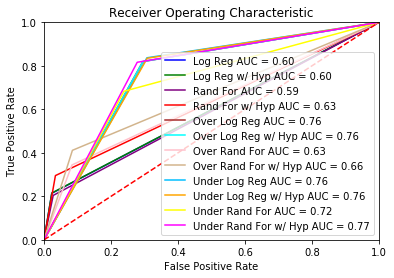

In [49]:
# calculate the fpr and tpr for all thresholds of the classification and plot
from sklearn import metrics
import matplotlib.pyplot as plt

# Logistic Regression
fpr, tpr, threshold = metrics.roc_curve(ytest, y_predict_test)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'blue', label = 'Log Reg AUC = %0.2f' % roc_auc)

# Logistic Regression with Hyperparameterization
fpr, tpr, threshold = metrics.roc_curve(ytest, ypred)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'green', label = 'Log Reg w/ Hyp AUC = %0.2f' % roc_auc)

# Random Forest
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredRF)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'purple', label = 'Rand For AUC = %0.2f' % roc_auc)

# Random Forest with Hyperparameterization
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredRF1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'red', label = 'Rand For w/ Hyp AUC = %0.2f' % roc_auc)

### Oversampled Data

# Logistic Regression (Oversampled)
fpr, tpr, threshold = metrics.roc_curve(ytest, y_predict_testLRO)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'brown', label = 'Over Log Reg AUC = %0.2f' % roc_auc)

# Logistic Regression with Hyperparameterization (Oversampled)
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredLROR)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'aqua', label = 'Over Log Reg w/ Hyp AUC = %0.2f' % roc_auc)

# Random Forest (Oversampled)
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredORF)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'pink', label = 'Over Rand For AUC = %0.2f' % roc_auc)

# Random Forest with Hyperparameterization (Oversampled)
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredORF1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'tan', label = 'Over Rand For w/ Hyp AUC = %0.2f' % roc_auc)

### Undersampled Data

# Logistic Regression (Undersampled)
fpr, tpr, threshold = metrics.roc_curve(ytest, y_predict_testLRU)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'deepskyblue', label = 'Under Log Reg AUC = %0.2f' % roc_auc)

# Logistic Regression with Hyperparameterization (Undersampled)
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredLRUR)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'orange', label = 'Under Log Reg w/ Hyp AUC = %0.2f' % roc_auc)

# Random Forest (Undersampled)
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredURF)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'yellow', label = 'Under Rand For AUC = %0.2f' % roc_auc)

# Random Forest with Hyperparameterization (Undersampled)
fpr, tpr, threshold = metrics.roc_curve(ytest, ypredURF1)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'fuchsia', label = 'Under Rand For w/ Hyp AUC = %0.2f' % roc_auc)

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# save plot to word doc for report
plt.savefig('/Users/Molfer/Documents/Lisa/Springboard/Capstone 1/DataClothing/Images/ROC.png')

plt.show()

Client's needs will have a large impact on which model to choose. While all clients will want to be conscious of how they spend their money, each client will have a different comfort level with the proportions of True Positive and False Positive results. In this case, Threads is a large clothing store that presumably has a larger budget. They may be more comfortable with a larger False Positive rate than a small nonprofit. With this in mind, we will proceed with the Logistic Regression with Hyperparameterization model from the Oversampled test run.

### Feature Importance

In [50]:

clfO.fit(X_Ores / np.std(X_Ores, 0), y_Ores)

features = pd.DataFrame(clfO.coef_)

features = pd.DataFrame(features.unstack())

features.columns = ['value']

features.reset_index(level=1,drop=True,inplace=True)

In [51]:
featurenames = pd.DataFrame(list(clothingFileLRnoRESP))
featurenames.columns = ['feature']

In [52]:
importance = pd.merge(featurenames, features, left_index=True, right_index=True)
print(importance.head())

    feature     value
0  ZIP_CODE  0.026575
1       REC -0.024648
2       FRE  0.739203
3       MON  0.329757
4   CC_CARD  0.050173


In [53]:
importance['absvalue'] = importance['value'].abs()

importanceSorted = importance.sort_values(by='absvalue',ascending=False)
print(importanceSorted.head(12))

         feature     value  absvalue
46      LTFREDAY -2.925280  2.925280
2            FRE  0.739203  0.739203
33       FREDAYS  0.530942  0.530942
24       CCSPEND -0.356145  0.356145
23       PSSPEND -0.333949  0.333949
3            MON  0.329757  0.329757
32          DAYS  0.290191  0.290191
43     RESPONDED -0.263444  0.263444
37        STYLES  0.195777  0.195777
44  RESPONSERATE  0.182652  0.182652
35       CLASSES -0.157704  0.157704
95   CLUSTYPE_47 -0.147341  0.147341


### Features

- 'LTFREDAY' - Lifetime average time between visits
- 'FRE' - Number of purchase visits
- 'FREDAYS' - Number of days between purchases
- 'CCSPEND' - Spending at the CC store
- 'PSSPEND' - Spending at the PS store
- 'MON' - Total net sales
- 'DAYS' - Number of days the customer has been on file
- 'RESPONDED' - Number of promotions responded to in the past year
- 'STYLES' - Total number of individual items purchased by the customer
- 'RESPONSERATE' - Promotion response rate for the past year - indicates which customers have ever responded to a marketing promotion before
- 'CLASSES' - Number of different product classes purchased
- 'CLUSTYPE' - Microvision lifestyle cluster type

The most important feature in the chosen Logistic Regression model is the 'Lifetime average time between visits'. The feature is a negative indicator, meaning as the average time between visits increases, the likelihood of the customer responding to the promotion goes down. The next six important features in the model have to do with the number of purchase visits, days the customer has been on file or spending amounts, including spending at individual stores. The four features after that are the customer's response to other promotions, the number of total products purchased, and the number of product classes the customer has purchased.

To increase customers response to promotions, I would set thresholds for each of these categories and target customers who met the thresholds. I would also identify which categories Threads would want to try and influence to expand the number of responsive customers. Threads ultimately wants increase the customers' rate of response to promotions to encourage customers to spend more money. The most important features that do not have to do directly with spending, (the category we want to increase) are customer visits and the number of different product classes purchased. I would work with Threads to identify ways to increase these metrics as well.